## Imports, etc

In [ ]:
#@title Dependencies
!pip install -q tree-sitter
!git clone https://github.com/r-lib/tree-sitter-r.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.2/488.2 kB 5.9 MB/s eta 0:00:00
Cloning into 'tree-sitter-r'...
remote: Enumerating objects: 1037, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 1037 (delta 229), reused 230 (delta 224), pack-reused 774
Receiving objects: 100% (1037/1037), 20.72 MiB | 20.76 MiB/s, done.
Resolving deltas: 100% (589/589), done.


## Scripts to extract identifiers

In [ ]:
from tree_sitter import Language, Parser

Language.build_library(
  # Store the library in the `build` directory
  'build/my-languages.so',
  # Include one or more languages
  [
    '/content/tree-sitter-r',
  ]
)

True

In [ ]:
r = Language('build/my-languages.so', 'r')

In [ ]:
parser = Parser()

In [ ]:
# def tree_to_token_index(root_node):
#     if (len(root_node.children) == 0 or root_node.type in ['string_literal', 'string',
#                                                            'character_literal']) and root_node.type != 'comment':
#         return [(root_node.start_point, root_node.end_point, root_node.type)]
#     else:
#         code_tokens = []
#         for child in root_node.children:
#             code_tokens += tree_to_token_index(child)
#         return code_tokens


def tree_to_token_index(root_node):
  code_tokens = []
  if(len(root_node.children)==0) and root_node.type != 'comment':
    return [(root_node.start_point, root_node.end_point, root_node.type)]
  else:
    if root_node.type != 'comment':
      code_tokens+=[(root_node.start_point, root_node.end_point, root_node.type)]
    # code_tokens = []
    for child in root_node.children:
        code_tokens += tree_to_token_index(child)
    return code_tokens

In [ ]:
def tree_to_variable_index(root_node, index_to_code):
    if (len(root_node.children) == 0 or root_node.type in ['string_literal', 'string',
                                                           'character_literal']) and root_node.type != 'comment':
        index = (root_node.start_point, root_node.end_point)
        _, code = index_to_code[index]
        if root_node.type != code:
            return [(root_node.start_point, root_node.end_point)]
        else:
            return []
    else:
        code_tokens = []
        for child in root_node.children:
            code_tokens += tree_to_variable_index(child, index_to_code)
        return code_tokens

In [ ]:
def index_to_code_token(index, code):
    start_point = index[0]
    end_point = index[1]
    if start_point[0] == end_point[0]:
        s = code[start_point[0]][start_point[1]:end_point[1]]
    else:
        s = ""
        s += code[start_point[0]][start_point[1]:]
        for i in range(start_point[0] + 1, end_point[0]):
            s += code[i]
        s += code[end_point[0]][:end_point[1]]
    return s

In [ ]:
# def get_type(parser, code, lang):
#     parser.set_language(lang)
#     # code = remove_comments_and_docstrings(code,lang)
#     tree = parser.parse(bytes(code, 'utf8'))
#     root_node = tree.root_node
#     tokens_index = tree_to_token_index(root_node)
#     code = code.split('\n')
#     code_tokens = [index_to_code_token(x, code) for x in tokens_index]
#     index_to_code = {}
#     for (index, code) in zip(tokens_index, code_tokens):
#         index_to_code[index] = code
#     return index_to_code

def get_type(parser, code, lang):
    parser.set_language(lang)
    # code = remove_comments_and_docstrings(code,lang)
    tree = parser.parse(bytes(code, 'utf8'))
    root_node = tree.root_node
    tokens_index = tree_to_token_index(root_node)
    code = code.split('\n')
    code_tokens = [index_to_code_token(x, code) for x in tokens_index]
    types = []
    for (index, code) in zip(tokens_index, code_tokens):
      # if index[0][1] in idx:
      types.append(index[2])
    return types

In [ ]:
def get_adv(parser, code, idx):
    parser.set_language(r)
    # code = remove_comments_and_docstrings(code,lang)
    tree = parser.parse(bytes(code, 'utf8'))
    root_node = tree.root_node
    tokens_index = tree_to_token_index(root_node)
    code = code.split('\n')
    code_tokens = [index_to_code_token(x, code) for x in tokens_index]
    # index_to_code = {}
    types = []
    for (index, code) in zip(tokens_index, code_tokens):
      if index[0][1] in idx:
        types.append(index[2])
    return types

### Extracting token type that was attacked and the frequency of attack on the tokens

In [ ]:
import pandas as pd
df = pd.read_json('/content/CodeAttack Generation.json')
df_success = df[df['pred_bleu']>df['after_attack_bleu']]

In [ ]:
def pos(code_og, code_adv):
  code_og_split = code_og.split()
  code_adv_split = code_adv.split()
  pos = 0
  pos_list = []
  for i in range(len(code_og_split)):
    if code_og_split[i] != code_adv_split[i]:
      pos_list.append(pos)
      # print(code_og_split[i], code_adv_split[i], pos, len(code_og_split[i]))
    # print(code_og_split[i])
    # print(code_og[pos])
    # print(50*'*')
    pos += len(code_og_split[i])+1
  return pos_list

In [ ]:
# code_og  = "function ( x , pars = character ( ) , regex_pars = character ( ) , transformations = list ( ) , ... , facet_args = list ( ) , binwidth = NULL , bins = NULL , breaks = NULL , freq = TRUE , alpha = 1 ) { check_ignored_arguments ( ... )  .mcmc_hist ( x , pars = pars , regex_pars = regex_pars , transformations = transformations , facet_args = facet_args , binwidth = binwidth , bins = bins , breaks = breaks , by_chain = FALSE , freq = freq , alpha = alpha , ... )  }"
# code_adv = "function ( x , pars = character ( ) , regex_pars = character ( ) , transformations = list ( ) , ... , facet_args = list ( ) , binwidth )= NULL , bins = NULL , breaks = NULL , freq = TRUE , alpha = 1 ) { check_ignored_arguments ( ... ) .mcmc_hist ( x , pars = pars , regex_pars = regex_pars , transformations = transformations , facet_args = facet_args , binwidth = binwidth , bins = bins , breaks = breaks , by_chain = FALSE s freq = freq , aci = as , ... ) }"

# idx = pos(code_og, code_adv)
# #replace all double spaces with single spaces
# code_og = code_og.replace('  ', ' ')

In [ ]:
# get_type(parser, code_og, r)

In [ ]:
all_tokens_ = list()
for index, row in df_success.iterrows():
  code_og = row.input
  code_adv = row.adv
  idx = pos(code_og, code_adv)
  code_og = code_og.replace('  ', ' ')
  all_tokens_+=get_type(parser, code_og, r)
import collections
all_tokens = collections.Counter(all_tokens_)
# all_tokens = sorted(all_tokens.items(), key=lambda item: (-item[1], item[0]))
all_tokens

Counter({'program': 448,
         'function_definition': 527,
         'function': 549,
         'formal_parameters': 541,
         '(': 4408,
         'identifier': 12007,
         ',': 4690,
         'default_parameter': 1116,
         '=': 2657,
         'call': 3445,
         ')': 4399,
         'dots': 352,
         'true': 130,
         'null': 415,
         'brace_list': 814,
         '{': 839,
         'arguments': 3433,
         'left_assignment': 541,
         '<-': 548,
         'default_argument': 1505,
         'dollar': 312,
         '$': 312,
         'if': 559,
         'binary': 1531,
         '==': 108,
         'float': 997,
         '}': 814,
         'string': 1403,
         '"': 2618,
         'ERROR': 20,
         'false': 200,
         '<': 20,
         '`': 4,
         'unary': 142,
         '!': 78,
         'namespace_get': 323,
         '::': 323,
         'slot': 35,
         '@': 35,
         '+': 71,
         'else': 94,
         '!=': 16,
         'escap

In [ ]:

types = list()
for index, row in df_success.iterrows():
  code_og = row.input
  code_adv = row.adv
  idx = pos(code_og, code_adv)
  code_og = code_og.replace('  ', ' ')
  types+=get_adv(parser, code_og, idx)
import collections
c = collections.Counter(types)


In [ ]:
# c = sorted(c.items(), key=lambda item: (-item[1], item[0]))
c

Counter({'default_parameter': 222,
         'identifier': 1793,
         'call': 439,
         '(': 478,
         ')': 506,
         ',': 754,
         'arguments': 405,
         '=': 533,
         'default_argument': 308,
         'unary': 30,
         '!': 7,
         'namespace_get': 77,
         '::': 72,
         'if': 69,
         'string': 277,
         '"': 272,
         'true': 14,
         'brace_list': 86,
         '{': 91,
         'left_assignment': 85,
         '<-': 86,
         'binary': 97,
         'slot': 26,
         '@': 26,
         '+': 8,
         'float': 95,
         '}': 110,
         'else': 17,
         'false': 28,
         'program': 48,
         'function_definition': 46,
         'function': 50,
         'dots': 44,
         'integer': 8,
         '%': 40,
         'dollar': 68,
         'for': 2,
         'in': 1,
         '==': 16,
         'subset2': 16,
         '[[': 16,
         ']]': 17,
         'subset': 12,
         '[': 14,
         '$': 76,


In [ ]:
def filter_tuples_by_threshold(tuple_list, threshold):
    filtered_tuples = [(key, value) for key, value in tuple_list if value >= threshold]
    return filtered_tuples

## Normalised Importance

In [ ]:
relative_imp = dict()
for key, value in all_tokens.items():
  print(key, c[key], all_tokens[key])
  relative_imp[key] = c[key]/all_tokens[key]


program 48 448
function_definition 46 527
function 50 549
formal_parameters 36 541
( 478 4408
identifier 1793 12007
, 754 4690
default_parameter 222 1116
= 533 2657
call 439 3445
) 506 4399
dots 44 352
true 14 130
null 106 415
brace_list 86 814
{ 91 839
arguments 405 3433
left_assignment 85 541
<- 86 548
default_argument 308 1505
dollar 68 312
$ 76 312
if 69 559
binary 97 1531
== 16 108
float 95 997
} 110 814
string 277 1403
" 272 2618
ERROR 4 20
false 28 200
< 2 20
` 0 4
unary 30 142
! 7 78
namespace_get 77 323
:: 72 323
slot 26 35
@ 26 35
+ 8 71
else 17 94
!= 6 16
escape_sequence 0 107
<= 0 12
equals_assignment 2 36
subset2 16 84
[[ 16 84
]] 17 84
' 16 188
subset 12 103
[ 14 103
] 12 103
integer 8 56
special 27 88
% 40 176
for 2 13
in 1 7
na 3 84
NA 2 77
switch 6 14
^ 0 185
* 9 300
- 24 313
>= 0 5
: 0 4
/ 4 391
> 1 12
|| 0 12
&& 6 22
~ 0 13
NA_real_ 1 6
; 1 3
& 14 24
paren_list 4 116
inf 0 84
nan 0 1
NA_character_ 0 1
| 0 2
namespace_get_internal 0 7
::: 1 7
pipe 0 1
|> 0 1


In [ ]:
relative_imp

{'program': 0.10714285714285714,
 'function_definition': 0.0872865275142315,
 'function': 0.09107468123861566,
 'formal_parameters': 0.066543438077634,
 '(': 0.10843920145190562,
 'identifier': 0.14932955775797452,
 ',': 0.1607675906183369,
 'default_parameter': 0.1989247311827957,
 '=': 0.20060218291305984,
 'call': 0.1274310595065312,
 ')': 0.11502614230506933,
 'dots': 0.125,
 'true': 0.1076923076923077,
 'null': 0.25542168674698795,
 'brace_list': 0.10565110565110565,
 '{': 0.10846245530393325,
 'arguments': 0.11797261870084474,
 'left_assignment': 0.15711645101663585,
 '<-': 0.15693430656934307,
 'default_argument': 0.20465116279069767,
 'dollar': 0.21794871794871795,
 '$': 0.24358974358974358,
 'if': 0.12343470483005367,
 'binary': 0.06335728282168518,
 '==': 0.14814814814814814,
 'float': 0.09528585757271815,
 '}': 0.13513513513513514,
 'string': 0.19743406985032075,
 '"': 0.1038961038961039,
 'ERROR': 0.2,
 'false': 0.14,
 '<': 0.1,
 '`': 0.0,
 'unary': 0.2112676056338028,
 '!'

In [ ]:
relative_imp_cp = relative_imp

In [ ]:
relative_imp = sorted(relative_imp.items(), key=lambda item: (-item[1], item[0]))
# relative_imp

In [ ]:
relative_imp_cp

{'program': 0.10714285714285714,
 'function_definition': 0.0872865275142315,
 'function': 0.09107468123861566,
 'formal_parameters': 0.066543438077634,
 '(': 0.10843920145190562,
 'identifier': 0.14932955775797452,
 ',': 0.1607675906183369,
 'default_parameter': 0.1989247311827957,
 '=': 0.20060218291305984,
 'call': 0.1274310595065312,
 ')': 0.11502614230506933,
 'dots': 0.125,
 'true': 0.1076923076923077,
 'null': 0.25542168674698795,
 'brace_list': 0.10565110565110565,
 '{': 0.10846245530393325,
 'arguments': 0.11797261870084474,
 'left_assignment': 0.15711645101663585,
 '<-': 0.15693430656934307,
 'default_argument': 0.20465116279069767,
 'dollar': 0.21794871794871795,
 '$': 0.24358974358974358,
 'if': 0.12343470483005367,
 'binary': 0.06335728282168518,
 '==': 0.14814814814814814,
 'float': 0.09528585757271815,
 '}': 0.13513513513513514,
 'string': 0.19743406985032075,
 '"': 0.1038961038961039,
 'ERROR': 0.2,
 'false': 0.14,
 '<': 0.1,
 '`': 0.0,
 'unary': 0.2112676056338028,
 '!'

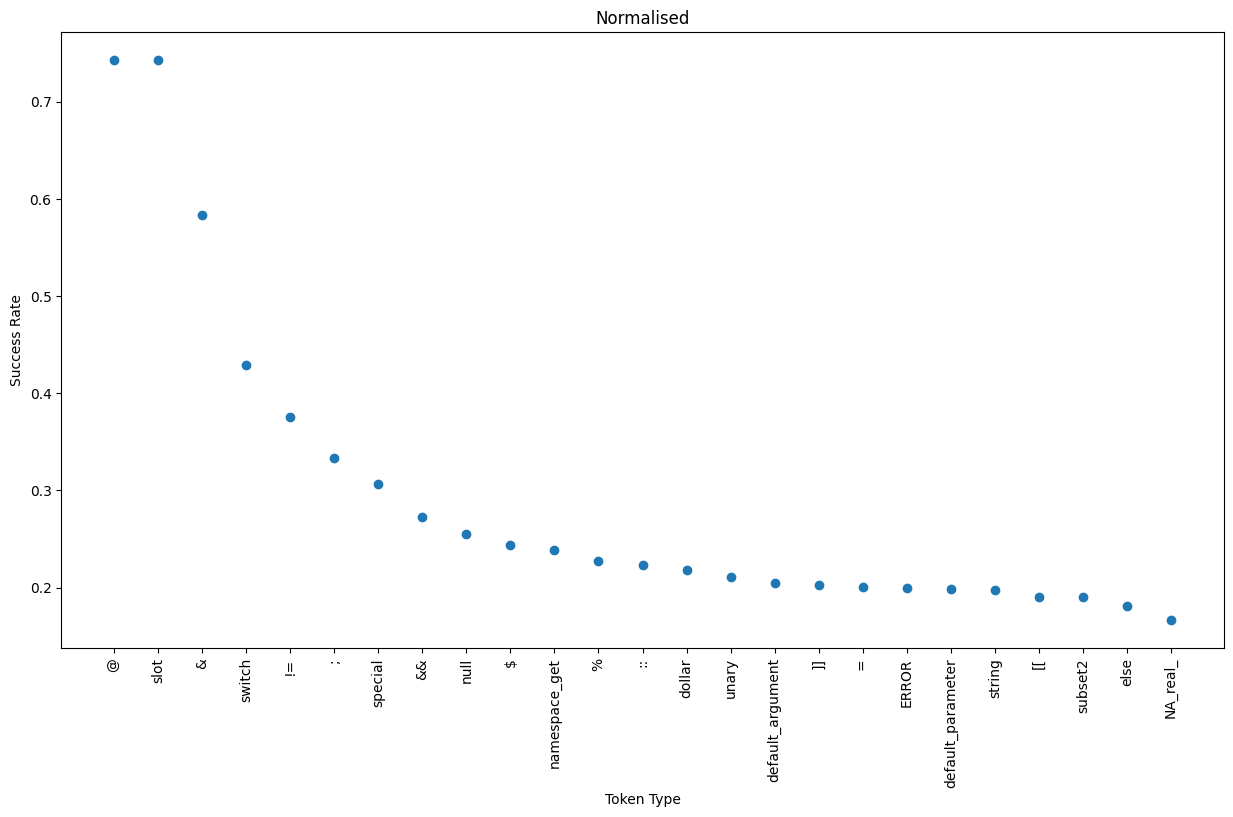

In [ ]:
import matplotlib.pyplot as plt

threshold_value = 0.1666666
relative_imp = filter_tuples_by_threshold(relative_imp, threshold_value)
# separate the first item of each tuple from th elist of tuples
labels = [i[0] for i in relative_imp]
y = [i[1] for i in relative_imp]
plt.figure(figsize=(15, 8))
plt.scatter(labels, y)
plt.xticks(rotation = 90)
plt.xlabel("Token Type")
plt.ylabel("Success Rate")
plt.title("Normalised")
plt.show()


## Importance

In [ ]:
num_attacks = 0
for key, value in c.items():
  num_attacks+=value

In [ ]:
num_attacks

7772

In [ ]:
freq_attack = dict()
for key, value in all_tokens.items():
  freq_attack[key]=c[key]/num_attacks



In [ ]:
importance = dict()
for key, value in freq_attack.items():
  importance[key] = relative_imp_cp[key]*freq_attack[key]

In [ ]:
importance = sorted(importance.items(), key=lambda item: (-item[1], item[0]))

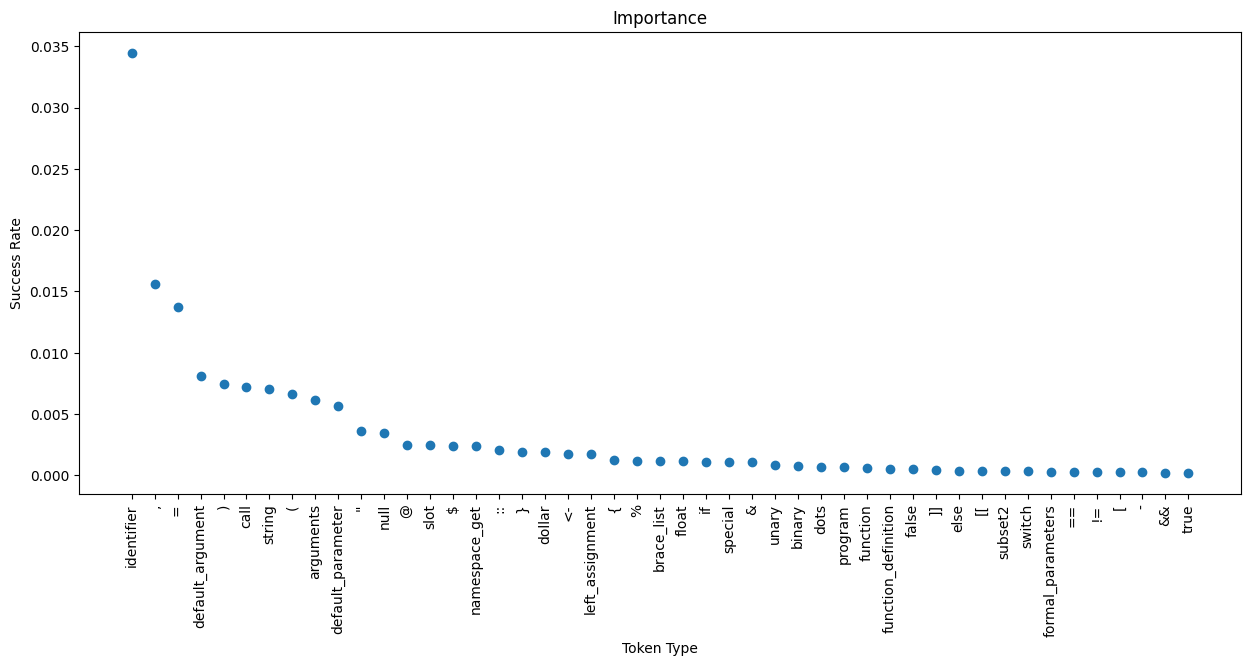

In [ ]:
# separate the first item of each tuple from th elist of tuples
threshold_value = 0.00018
importance = filter_tuples_by_threshold(importance, threshold_value)
labels = [i[0] for i in importance]
y = [i[1] for i in importance]
plt.figure(figsize=(15, 6))
plt.scatter(labels, y)
plt.xlabel("Token Type")
plt.ylabel("Success Rate")
plt.title("Importance")
plt.xticks(rotation = 90)
plt.show()

##  Un-normalised

In [ ]:

c = sorted(c.items(), key=lambda item: (-item[1], item[0]))

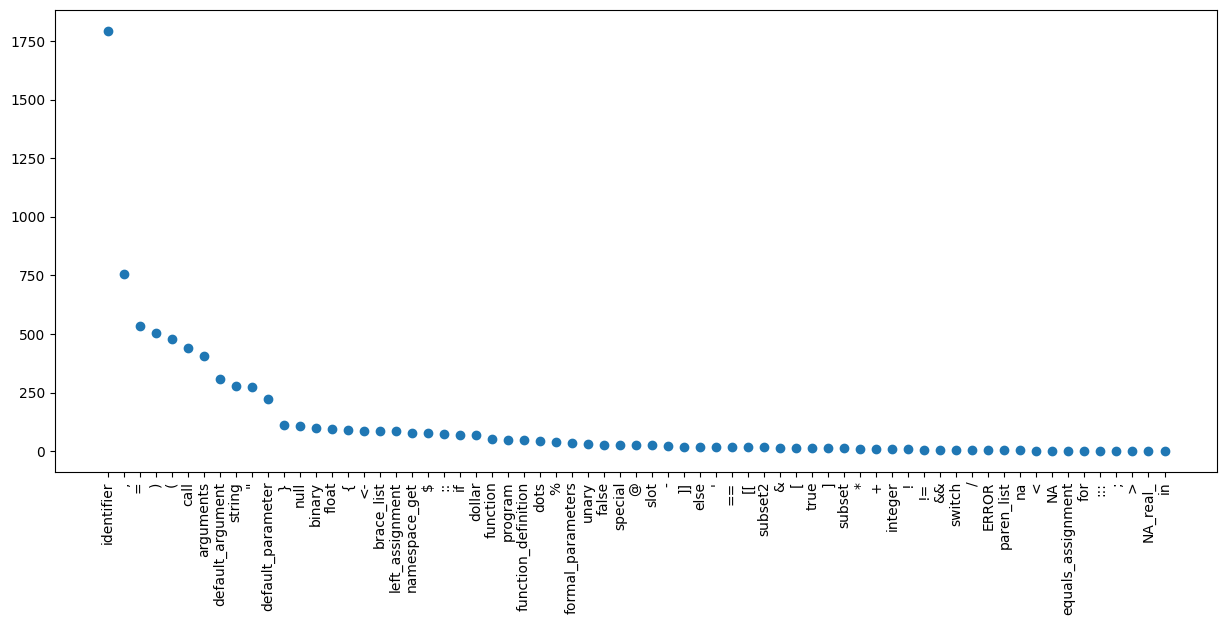

In [ ]:
# separate the first item of each tuple from th elist of tuples
labels = [i[0] for i in c]
y = [i[1] for i in c]
plt.figure(figsize=(15, 6))
plt.scatter(labels, y)
plt.xticks(rotation = 90)
plt.show()


## ignore

In [ ]:
code_og = "function ( cohortData , ... ) { predObj <- unique ( cohortData [ , . ( pixelGroup , age , speciesCode ) ] )  predObj [ , ` ` ( mortPred = 100 , growthPred = 100 ) ]  return ( predObj )  }"

In [ ]:
# code_set = [(code_og,r)]

In [ ]:
get_type(parser, code_og, r)

In [ ]:
code_og1 = """
function ( cohortData , ... ) {
  predObj <- unique ( cohortData [ , . ( pixelGroup , age , speciesCode ) ] )
  predObj [ , ` ` ( mortPred = 100 , growthPred = 100 ) ]
  return ( predObj )  }
"""

In [ ]:
get_type(parser, code_og1, r)


In [ ]:
# import pprint
# for code, lang in code_set:
#     print('*'*100)
#     print("Original Code")
#     print(code)
#     print("_"*100)
#     print("Parsed Identifiers")
#     pprint.pprint(get_adv(parser, code, lang, idx))
#     print('*'*100)